# Welcome!

Developers: Joseph Bentivegna, Ariana Freitag, Matthew Grattan  
Advisor: Professor Sam Keene  
Institution: The Cooper Union for the Advancement of Science and Art  

## Motivation
The approach we took to analyzing the provided data is focused primarily around the challenge stated in the problem statement: automating the combination of police data, census-level data, and other socioeconomic factors. Since the ultimate goal of the CPE is to inform police agencies where they can make improvements by identifying areas of racial disparity, our kernel aims to provide a tool to the CPE that **combines police data and census-level data into a comprehensive dataset that is ready for out-of-the-box unsupervised machine learning**.  We believe that applying unsupervised machine learning algorithms to police and census data can prove useful to identify areas of racial disparity because they can capture inter-district discrepancies in quality of service.

## Approach
Our methodology consists of 3 main parts.  

#### 1. Census Data Preprocessing 
This first part consists of mapping census-level data to police districts by using the provided department shapefiles.  Since we are going to be overlaying district mappings and census mappings, we also need shapefiles for the census data.  We used [Data](https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html) from the US Government Census Tracts to import state-wide census-tract data for all of the necessary states.  For each department we then calculated the *intersection* of each district with the census tract.  This allowed us to get the percentage of geographical area that each census-tract is in each district.  When combined with the ACS data, these percentages enable us to calculate accurate numbers for demographic data in each district, in each department.

#### 2. Crime and Use of Force Prerocessing 
In order to look at the six cities we selected, the data needed to aggregated with common labels and grouped by the police districts within each city. This step was focused on processing the individual city data, focusing on race, gender, and crime or use of force records. We aggregated the data as average per year, over each district in the city. Crimes were grouped into the labels 'non-violent', 'violent', and 'non-criminal', and Use of Force was grouped into 'Use of Physical Force', 'Use of Non-Lethal Weapon', 'Use of Lethal Weapon', and 'Fatal Use of Weapon'. Gender was grouped by 'Male', 'Female', and 'Not Listed'. The Race label was grouped by 'Native American', 'Asian', 'Black', 'Latinx', 'Pacific Islander', 'White', 'Bi-Racial', and 'Not Listed'. These specific group labels were based on the data recorded by each of the police forces  and  online resources describing what a violent vs non-violent crime, and the different categories of use of force. The output of this section is six independent dataframes, one for each city, with district as the primary identifier and common labels accross all six.

#### 3. Bringing it All Together 
This final step brings together the outputs from the previous steps.  We essentially perform a left merge on the district level census data and the police data to produce a single dataframe with all of the columns (features) we want for each district. Then, we concatenate all of the individual departments together to create one comprehensive *CPE DATASET*.  This dataset contains approximately 100 observations from districts across the U.S. and 39 unique features that describe aggregates of crime, use of force, and demographic information. 


## Notes/Assumptions/References
1. Much of the inspiration for the first part of our code was taken from 
Crystal Blankenship's [GeoAnalysis: Map Police Dept. to Census for Equity](https://www.kaggle.com/crystalblankenship/geoanalysis-map-police-dept-to-census-for-equity/code)
2. We selected not to use departments where we were unable to read the shapefiles as is. 
3. We assumed that in the census data population is uniformly distributed over the land of each tract.
4. Census data is aggregared using the addition operator. This choice was made to keep consistency, as aggregating on mean does not make sense in this context. For example, if a tract was only a small percentage of geographical area of a district, the seemingly small median income would greatly skew the data.
5. There is bias in the grouping of Use of Force and Crime, as threre is no strict definition to what the different types of force and crime are considered. These data points were grouped based on the sources below.  
[Use of Force Levels](https://www.nij.gov/topics/law-enforcement/officer-safety/use-of-force/Pages/continuum.aspx)  
[Violent vs Non-Violent Crimes](https://www.fightforyourrightsmn.com/blog/2016/12/the-difference-between-violent-and-non-violent-crimes.shtml)
6. The race codes for Los Angeles were found in [LA's Open Data](https://data.lacity.org/A-Safe-City/Arrest-Data-from-2010-to-Present/yru6-6re4).  The different countries located in Asia were aggregated under the 'Asian' label.

## Final Note...
Unfortunately **this notebook is not going to actually produce anything when run**.  The code worked on our local system when developing in Jupyter Notebook but we encountered an error we were unable to rectify when porting the code to kaggle.  That being said, not all hope is lost. Since the code runs on our local machines we have simply saved the intermediary steps and imported them into this submission so that they can be used by all :)

In [1]:
# imports
import numpy as np
import pandas as pd
import geopandas as geopd
import os
import folium
import collections
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# initializations
shapefile_set = {'shapefile_data': {}, 'shapefile_crs': {}, 'shapefile_geom_type': {}}
ACS_set = {}
census_shapefile_set = {}
intersection_set = {}
districts_set = {}
combined_set = {}

## Part 1: Census Data Preprocessing

In [3]:
# Get list of directories
departments = [name for name in os.listdir() if os.path.isdir(os.path.join(name))]
departments.remove(".ipynb_checkpoints")
departments.remove("census-tract-shapefile")
departments.remove("intersection-files")
departments.remove("figs")
print("Found departments: ", departments, "\n")

Found departments:  ['Dept_11-00091', 'Dept_23-00089', 'Dept_24-00013', 'Dept_24-00098', 'Dept_35-00016', 'Dept_35-00103', 'Dept_37-00027', 'Dept_37-00049', 'Dept_49-00009', 'Dept_49-00033', 'Dept_49-00035', 'Dept_49-00081'] 



In [5]:
# Read in shapefile data for each department using geopandas
for department in departments:
    sub_directories = os.listdir(department)
    shapefile_directory  = ''.join([f for f in sub_directories if "Shapefiles" in f])
    shapefiles = os.listdir(os.path.join(department, shapefile_directory))
    shapefiles = [f for f in shapefiles if f.endswith('.shp')]
    if len(shapefiles) > 1:
        shapefiles = shapefiles[0]
    shapefile = ''.join(shapefiles)
    data_file = os.path.join(department, shapefile_directory, shapefile)
    
    data = geopd.read_file(data_file)
    shapefile_set['shapefile_data'][shapefile] = data
    shapefile_set['shapefile_crs'][shapefile] = data.crs
    shapefile_set['shapefile_geom_type'][shapefile] = data.geom_type.unique().tolist()
                
#GET SHAPEFILES THAT ARE POINTS BC CANNOT DO INTERSECTION AND AREA CALCS WITH POINTS!
point_shapefiles = [s for s,g in shapefile_set['shapefile_geom_type'].items() if 'Point' in g or 'Line' in g]
#GET SHAPEFILES WITH NO COORDINATE SYSTEM BC CANNOT DO INTERSECT WITHOUT CRS!
CRS_missing_shapefiles = [s for s,g in shapefile_set['shapefile_crs'].items() if not g]

#PRINT DATA FINDINGS
print("Found shapefiles: %s" % (tuple(shapefile_set['shapefile_data'].keys()),), '\n')
#SHOW WARNINGS FOR SHAPEFILES THAT WILL NOT BE PROCESSED
if point_shapefiles:
    print("WARNING: Shapefiles with incorrect geometry found. Cannot porcess shapefiles: %s" % (point_shapefiles,))
if CRS_missing_shapefiles:
    print("WARNING: Shapefiles with missing CRS found. Cannot porcess shapefiles: %s" % (CRS_missing_shapefiles,))

Found shapefiles: ('boston_police_districts_f55.shp', 'Indianapolis_Police_Zones.shp', 'Minneapolis_Police_Precincts.shp', 'StPaul_geo_export_6646246d-0f26-48c5-a924-f5a99bb51c47.shp', 'OrlandoPoliceDistricts.shp', 'CMPD_Police_Division_Offices.shp', 'APD_DIST.shp', 'EPIC.shp', 'SPD_BEATS_WGS84.shp', 'lapd division.shp', 'Oakland_geo_export_e0633584-8d50-406e-b9d6-e33545fdae16.shp', 'SFPD_geo_export_8a7e3c3b-8d43-4359-bebe-b7ef6a6e21f3.shp') 



In [6]:
# Read in ACS data for each department using pandas
for department in departments:
    sub_directories = os.listdir(department)
    ACS_directory  = ''.join([f for f in sub_directories if "ACS" in f])
    ACS_sub_directories = os.listdir(os.path.join(department, ACS_directory))
    ACS_set[ACS_directory] = {}
    for ACS_sub_directory in ACS_sub_directories:
        if os.path.isdir(os.path.join(department, ACS_directory, ACS_sub_directory)) == True:
            ACS_data_type = ACS_sub_directory.split('_')[-1]
            for ACS_file in os.listdir(os.path.join(department, ACS_directory, ACS_sub_directory)):
                if 'metadata' not in ACS_file:
                    data_file = os.path.join(department, ACS_directory, ACS_sub_directory, ACS_file)
                    data = pd.read_csv(data_file)
                    if data.empty:
                        pass
                    else:
                        data.columns = data.iloc[0,:]
                        data=data.iloc[1:,:]
                    ACS_set[ACS_directory][ACS_data_type] = data
                        
# Print findings
print ("Found ACS data: ", ACS_set.keys(), "\n")
print ("Found types for boston: ", ACS_set['11-00091_ACS_data'].keys(), "\n")

Found ACS data:  dict_keys(['11-00091_ACS_data', '23-00089_ACS_data', '24-00013_ACS-data', '24-00098_ACS-data', '35-00016_ACS-data', '35-00103_ACS_data', '37-00027_ACS_data', '37-00049_ACS_data', '49-00009_ACS_data', '49-00033_ACS-data', '49-00035_ACS-data', '49-00081_ACS-data']) 

Found types for boston:  dict_keys(['education-attainment', 'education-attainment-over-25', 'employment', 'income', 'owner-occupied-housing', 'poverty', 'race-sex-age']) 



In [7]:
city_to_census_state = {'boston': '25',
                        'indianapolis': '18',
                        'minneapolis': '27',
                        'st. paul': '27',
                        'orlando': '12',
                        'charlotte': '37',
                        'austin': '48',
                        'dallas': '48',
                        'seattle': '53',
                        'los angeles': '06',
                        'oakland': '06',
                        'san francisco': '06'}

# Read in census tract data
census_dir = 'census-tract-shapefile'
census_directories = os.listdir(census_dir)
for c_sub_directory in census_directories:
    files = os.listdir(os.path.join(census_dir, c_sub_directory))
    for file in [f for f in files if f.endswith('.shp')]:
        state_ID = file.split('_')[2]
        shapefile = os.path.join(census_dir, c_sub_directory, file)
        data = geopd.read_file(shapefile)
        census_shapefile_set[state_ID] = data
        
print("census shapefiles loaded for: ", census_shapefile_set.keys())
print("Census example data:")
print(census_shapefile_set[city_to_census_state['indianapolis']].iloc[0])

census shapefiles loaded for:  dict_keys(['06', '12', '18', '25', '27', '37', '48', '53'])
Census example data:
STATEFP                                                    18
COUNTYFP                                                  001
TRACTCE                                                030100
AFFGEOID                                 1400000US18001030100
GEOID                                             18001030100
NAME                                                      301
LSAD                                                       CT
ALAND                                               201061799
AWATER                                                 364316
geometry    POLYGON ((-85.07386099999999 40.917823, -85.05...
Name: 0, dtype: object


In [8]:
city_to_shape = {'boston':'boston_police_districts_f55.shp',
                'indianapolis':'Indianapolis_Police_Zones.shp',
                'minneapolis':'Minneapolis_Police_Precincts.shp',
                'st. paul':'StPaul_geo_export_6646246d-0f26-48c5-a924-f5a99bb51c47.shp',
                'orlando':'OrlandoPoliceDistricts.shp',
                'charlotte':'CMPD_Police_Division_Offices.shp',
                'austin':'APD_DIST.shp',
                'dallas':'EPIC.shp',
                'seattle':'SPD_BEATS_WGS84.shp',
                'los angeles':'lapd division.shp',
                'oakland':'Oakland_geo_export_e0633584-8d50-406e-b9d6-e33545fdae16.shp',
                'san francisco':'SFPD_geo_export_8a7e3c3b-8d43-4359-bebe-b7ef6a6e21f3.shp'}

city_utm_crs = {'boston': None,
                'indianapolis': None,
                'minneapolis': None,
                'st. paul': None,
                'orlando': None,
                'charlotte': {'init': 'epsg:4326'},
                'austin': {'init': 'epsg:102739'},
                'dallas': {'init': 'epsg:102738'},
                'seattle': {'init': 'epsg:32610'},
                'los angeles': None,
                'oakland': None,
                'san francisco': None}

error computing intersects for boston
computed intersects for indianapolis


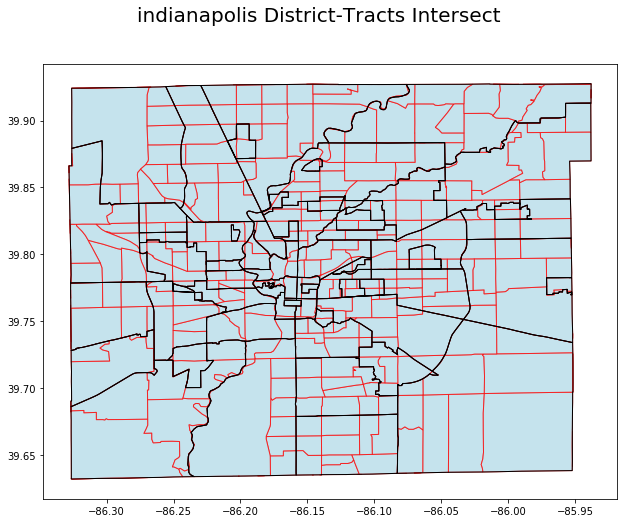

(591, 2124)
computed intersects for minneapolis


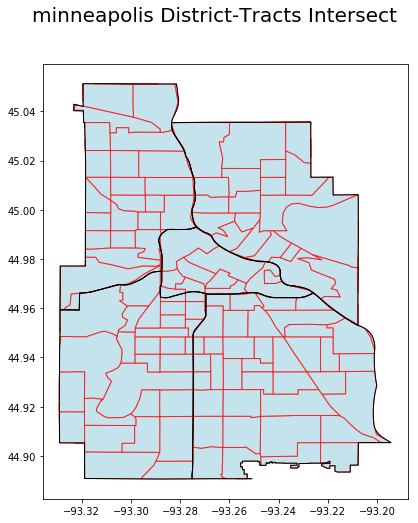

(179, 2122)
computed intersects for st. paul


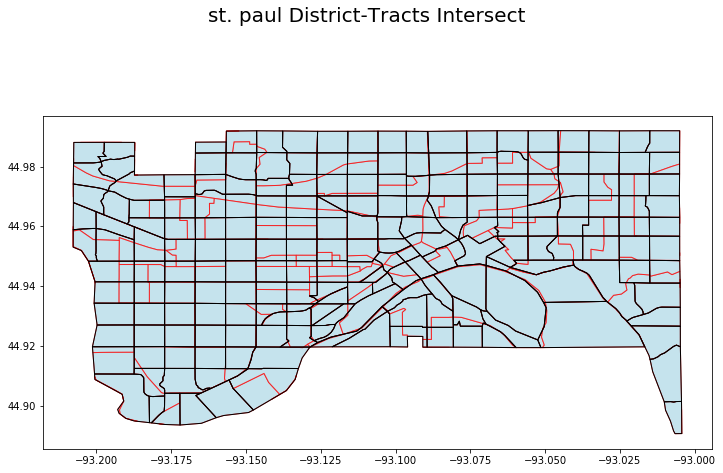

(636, 1997)
error computing intersects for orlando
updated:  charlotte
error computing intersects for charlotte
error computing intersects for austin
error computing intersects for dallas
updated:  seattle
computed intersects for seattle


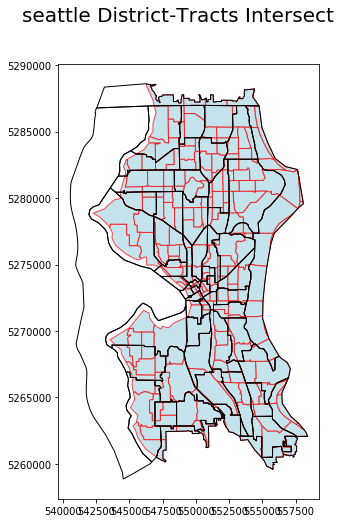

(437, 2123)
computed intersects for los angeles


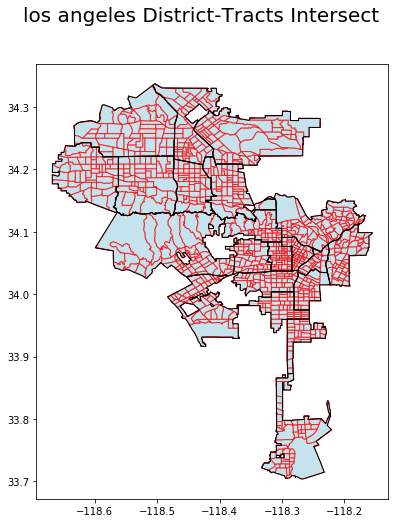

(1269, 2130)
computed intersects for oakland


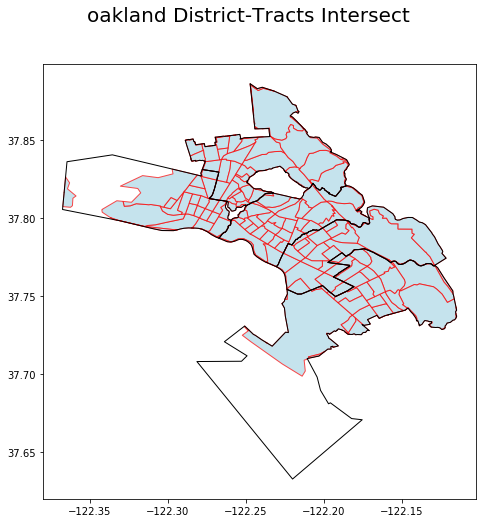

(188, 2121)
computed intersects for san francisco


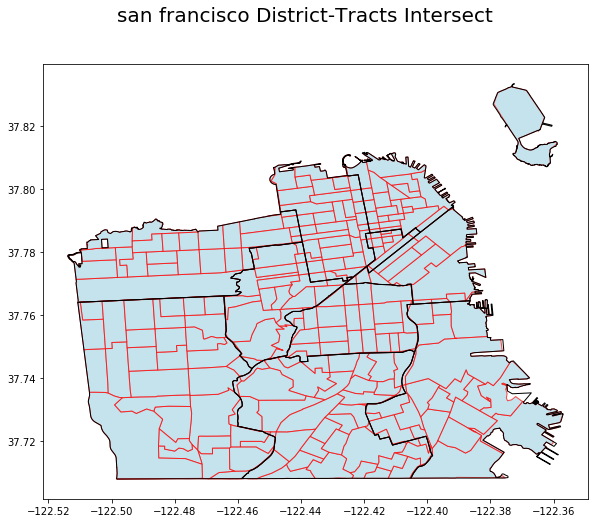

(283, 2123)


In [9]:
# square meters to square feet
sqm_to_sqft = 10.7639

# plot figures or not
plotting = True
loc = -1

# iterate through cities and compute intersect for each police district
for city in city_to_shape.keys():
    loc += 1
    try:
        # update CRS if necessary
        crs = city_utm_crs[city]
        if crs is not None:
            districts = shapefile_set['shapefile_data'][city_to_shape[city]].to_crs(crs=crs)
            tracts = census_shapefile_set[city_to_census_state[city]].to_crs(crs=crs)
            print ("updated: ", city)
        else:
            districts = shapefile_set['shapefile_data'][city_to_shape[city]]
            tracts = census_shapefile_set[city_to_census_state[city]]
        
        # compute areas
        tracts['area_sqm_tract'] = tracts.geometry.area
        tracts['area_sqft_tract'] = tracts.geometry.area*sqm_to_sqft

        # compute intersection between district and census tracts
        intersection = geopd.overlay(districts, tracts, how='intersection')
        print ("computed intersects for", city)
        
        # plotting
        if plotting:
            fig,ax = plt.subplots(figsize=(12,8))
            ax.set_aspect('equal')
            fig.suptitle(str(city) + ' District-Tracts Intersect', fontsize=20)
            intersection.plot(ax=ax, color='lightblue', edgecolor='red', alpha=0.7)
            districts.plot(ax=ax, color='none', facecolor='none', edgecolor='black')
            plt.savefig('figs\\'+str(city)+' District-Tracts Intersection.png')
            plt.show()
        
    except:
        print ("error computing intersects for", city)
        continue
    
    # compute areas after intersection
    intersection['area_sqm_tract_inter'] = intersection.geometry.area
    intersection['area_sqft_tract_inter'] = intersection.geometry.area*sqm_to_sqft
    
    # compute percentage of tract in police district
    intersection['tract_perc_in_div'] =  intersection['area_sqm_tract_inter']/intersection['area_sqm_tract'] 
    
    # merge in ACS data based on GEOID
    for ii in ACS_set[list(ACS_set.keys())[loc]].keys():
        ACS_set[list(ACS_set.keys())[loc]][ii]['GEOID'] = ACS_set[list(ACS_set.keys())[loc]][ii]['Id2']
        intersection = intersection.merge(ACS_set[list(ACS_set.keys())[loc]][ii], on='GEOID')
        
    print (intersection.shape)
    intersection.to_csv("intersection-files\\raw-intersection\\intersection for "+str(city)+".csv")
    intersection_set[city] = intersection

In [10]:
# list of column names of ACS data to use
column_names = ["GEOID", "geometry", "tract_perc_in_div",
                "Percent; Estimate; Population 25 years and over - High school graduate (includes equivalency)",
                "Percent; Estimate; Population 25 years and over - Bachelor's degree",
#                 "Total; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings",
#                 "Males; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings",
#                 "Females; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings",
                "Employment/Population Ratio; Estimate; Population 16 years and over",
                "Unemployment rate; Estimate; Population 16 years and over",
                "Median income (dollars); Estimate; Households",
                "Median income (dollars); Estimate; Households - One race-- - White",
                "Median income (dollars); Estimate; Households - One race-- - Black or African American",
                "Median income (dollars); Estimate; Households - One race-- - Asian",
                "Median income (dollars); Estimate; Households - One race-- - Some other race",
                "Occupied housing units; Estimate; Occupied housing units",
                "Owner-occupied housing units; Estimate; Occupied housing units",
                "Renter-occupied housing units; Estimate; Occupied housing units",
                "Percent below poverty level; Estimate; Population for whom poverty status is determined",
                "Estimate; SEX AND AGE - Total population",
                "Percent; SEX AND AGE - Total population - Male",
                "Percent; SEX AND AGE - Total population - Female",
                "Estimate; SEX AND AGE - Median age (years)",
                "Percent; RACE - One race - White",
                "Percent; RACE - One race - Black or African American",
                "Percent; RACE - One race - Asian",
                "Percent; RACE - One race - Some other race"]

In [11]:
# district dictionary to map cities to identifying column
district_identifiers = {'indianapolis':'DISTRICT', 
                        'minneapolis':'PRECINCT', 
                        'los angeles':'external_i', 
                        'oakland':'pol_dist',
                        'san francisco':'district',
                        'seattle':'beat'}

# iterate over cities 
for city in intersection_set.keys():
    
    # ignore st. paul b/c it only has vehicle data which we dont really care about
    if city != "st. paul":
        
        # retrieve city data from set
        intersection_data = intersection_set[city]
        
        # insert identifier into column list but remove it after
        column_names.insert(0, district_identifiers[city])
        intersection_data = intersection_data[column_names]
        del column_names[0]

        # make sure all values that we are doing calculations on are floats
        intersection_data.iloc[:,3:] = intersection_data.iloc[:,3:].apply(pd.to_numeric, errors='coerce')
        intersection_data.iloc[:,3:] = intersection_data.iloc[:,3:].fillna(0)
        intersection_data.iloc[:,3:] = intersection_data.iloc[:,3:].astype(float)

        # multiply all census columns by district ratios
        intersection_data.iloc[:,4:] = intersection_data.iloc[:,4:].multiply(intersection_data.iloc[:,3], axis='index')

        # dissolve intersection data to aggregate information
        districts_aggregated = intersection_data.dissolve(by=district_identifiers[city], aggfunc='sum')
        
        # clean up data, write to csv, and store in dict
        districts_printable = districts_aggregated.drop(labels=['geometry', 'tract_perc_in_div'], axis=1)
        districts_printable.to_csv("intersection-files\\dissolved-intersection\\agg for "+str(city)+".csv")
        districts_set[city] = districts_printable
        print ("finished processing: ", str(city))

finished processing:  indianapolis
finished processing:  minneapolis
finished processing:  seattle
finished processing:  los angeles
finished processing:  oakland
finished processing:  san francisco


## Part 2: Crime and Use of Force Preprocessing¶

In [12]:
Bos = pd.read_csv("Dept_11-00091\\11-00091_Field-Interviews_2011-2015.csv")
Bos = Bos.drop(Bos.index[0])

Ind = pd.read_csv("Dept_23-00089\\23-00089_UOF-P.csv")
Ind = Ind.drop(Ind.index[0])

Minn = pd.read_csv("Dept_24-00013\\24-00013_UOF_2008-2017_prepped.csv")
Minn = Minn.drop(Minn.index[0])

Sea = pd.read_csv("Dept_49-00009\\49-0009_UOF.csv")
Sea = Sea.drop(Sea.index[0])

La = pd.read_csv("Dept_49-00033\\49-00033_Arrests_2015.csv")
La = La.drop(La.index[0])

Oak = pd.read_csv("Dept_49-00035\\49-00035_Incidents_2016.csv")
Oak = Oak.drop(Oak.index[0])

Sf = pd.read_csv("Dept_49-00081\\49-00081_Incident-Reports_2012_to_May_2015.csv")
Sf = Sf.drop(Sf.index[0])

In [13]:
# Seattle

# convert M/D/Y to date type then only the year
Sea['INCIDENT_DATE'] = pd.to_datetime(Sea['INCIDENT_DATE'])
Sea['INCIDENT_DATE'] = Sea['INCIDENT_DATE'].dt.year

# copy the raw data into the new data frame, change the header titles, one hot encode Use of force, race, and gender
Seattle = Sea[['INCIDENT_DATE', 'TYPE_OF_FORCE_USED', 'LOCATION_DISTRICT.2', 'SUBJECT_RACE', 'SUBJECT_GENDER']].copy()
Seattle.columns = 'Date', 'UOF', 'District', 'Race', 'Gender'
Seattle = pd.get_dummies(data=Seattle, columns=['UOF', 'Race', 'Gender'])

# group by district and year and sum over the labels, see total count per district and year
SeaGroup = Seattle.groupby(['District', 'Date']).sum()

# change header titles, add empty columns for data that other cities have, sort the columns in consistent order
SeaGroup.columns = 'UOF_Use of Physical Force', 'UOF_Use of Non-Lethal Weapon', 'UOF_Use of Lethal Weapon', 'UOF_Fatal Use of Weapon', 'Race_Native American', 'Race_Asian', 'Race_Black', 'Race_Latinx', 'Race_Pacific Islander','Race_Not Listed','Race_White', 'Gender_Female', 'Gender_Male', 'Gender_Not Listed'
SeaGroup = SeaGroup.assign(**{'City':'Seattle','Race_Bi-Racial': np.nan, 'Crime_Violent': np.nan, 'Crime_Non-Violent':np.nan, 'Crime_Non-Criminal':np.nan})
SeaGroup = SeaGroup.reset_index(level=['District', 'Date'])
SeaGroup = SeaGroup[['District','City', 'Date', 'UOF_Use of Physical Force', 'UOF_Use of Non-Lethal Weapon', 'UOF_Use of Lethal Weapon', 'UOF_Fatal Use of Weapon', 'Crime_Violent', 'Crime_Non-Violent', 'Crime_Non-Criminal', 'Race_Native American', 'Race_Asian', 'Race_Black', 'Race_Latinx', 'Race_Pacific Islander','Race_Not Listed','Race_White', 'Race_Bi-Racial', 'Gender_Male', 'Gender_Female', 'Gender_Not Listed']].copy()

# find the mean of the total count of labels over year
SeaGroup = SeaGroup.drop('Date', axis=1)
SeaGroup = SeaGroup.groupby(['District']).mean()
SeaGroup = SeaGroup.assign(**{'City':'Seattle'})

In [14]:
# Indianapolis

# convert M/D/Y to date type then only the year
Ind['INCIDENT_DATE'] = pd.to_datetime(Ind['INCIDENT_DATE'])
Ind['INCIDENT_DATE'] = Ind['INCIDENT_DATE'].dt.year

# copy the raw data into the new data frame, change the header titles
Indianapolis = Ind[['INCIDENT_DATE', 'LOCATION_DISTRICT', 'TYPE_OF_FORCE_USED', 'SUBJECT_RACT', 'SUBJECT_GENDER']].copy()
Indianapolis.columns = 'Date', 'District', 'UOF', 'Race', 'Gender'

# manually group use of force types into the 3 categories, replace the data points with the category labels
Indianapolis['UOF'] = Indianapolis['UOF'].replace(['Less Lethal-Pepperball','Less Lethal-Personal CS/OC spray','Less Lethal-Taser','Canine Bite','Less Lethal-Bean Bag', 'Less Lethal-Baton', 'Less Lethal-CS/OC', 'Less Lethal-BPS Gas', 'Less Lethal-Clearout OC', 'Less Lethal-CS Fogger', 'Less Lethal-Flash Bang', 'Less Lethal-Bps Gas', 'Less Lethal-CS Grenade'], 'Use of Non-Lethal Weapon')
Indianapolis['UOF'] = Indianapolis['UOF'].replace(['Less Lethal-Burning CS','Less Lethal-Other','Physical-Hands, Fist, Feet','Physical-Handcuffing', 'Physical-Weight Leverage', 'Physical-Joint/Pressure', 'Physical-Take Down', 'Physical-Leg Sweep', 'Physical-Kick', 'Physical-Palm Strike', 'Physical-Knee Strike','Physical-Fist Strike', 'Physical-Elbow Strike', 'Physical-Push','Physical-Other' ], 'Use of Physical Force')
Indianapolis['UOF'] = Indianapolis['UOF'].replace(['Lethal-Vehicle','Lethal-Handgun'], 'Use of Lethal Weapon')
# replace race datapoint with common name
Indianapolis['Race'] = Indianapolis['Race'].replace('Other', 'Not Listed')

# one hot encode use of force, race, and gender
Indianapolis = pd.get_dummies(data=Indianapolis, columns=['UOF', 'Race', 'Gender'])

# group by year and district
IndGroup = Indianapolis.groupby(['District', 'Date']).sum()

# change header titles, add empty columns for data that other cities have, sort the columns in consistent order
IndGroup.columns = 'UOF_Use of Lethal Weapon', 'UOF_Use of Non-Lethal Weapon', 'UOF_Use of Physical Force', 'Race_Asian', 'Race_Bi-Racial', 'Race_Black', 'Race_Latinx', 'Race_Native American', 'Race_Other', 'Race_Pacific Islander', 'Race_Not Listed', 'Race_White', 'Gender_Female','Gender_Male', 'Gender_Not Listed'
IndGroup = IndGroup.assign(**{'City':'Indianapolis','Race_Bi-Racial': np.nan, 'Crime_Violent': np.nan, 'Crime_Non-Violent':np.nan, 'Crime_Non-Criminal':np.nan, 'UOF_Fatal Use of Weapon':np.nan})
IndGroup = IndGroup.reset_index(level=['District', 'Date'])
IndGroup = IndGroup[['District','City', 'Date', 'UOF_Use of Physical Force', 'UOF_Use of Non-Lethal Weapon', 'UOF_Use of Lethal Weapon', 'UOF_Fatal Use of Weapon', 'Crime_Violent', 'Crime_Non-Violent', 'Crime_Non-Criminal', 'Race_Native American', 'Race_Asian', 'Race_Black', 'Race_Latinx', 'Race_Pacific Islander','Race_Not Listed','Race_White', 'Race_Bi-Racial', 'Gender_Male', 'Gender_Female', 'Gender_Not Listed']].copy()

# find the mean of the total count of labels over year
IndGroup = IndGroup.drop('Date', axis=1)
IndGroup = IndGroup.groupby(['District']).mean()
IndGroup = IndGroup.assign(**{'City':'Indianapolis'})

In [15]:
# Minneapolis

# convert M/D/Y to date type then only the year
Minn['INCIDENT_DATE'] = pd.to_datetime(Minn['INCIDENT_DATE'])
Minn['INCIDENT_DATE'] = Minn['INCIDENT_DATE'].dt.year

# copy the raw data into the new data frame, change the header titles
# make sure column has same type
Minneapolis = Minn[['INCIDENT_DATE', 'LOCATION_DISTRICT', 'TYPE_OF_FORCE_USED', 'SUBJECT_RACE', 'SUBJECT_GENDER']].copy()
Minneapolis.columns = 'Date', 'District', 'UOF', 'Race', 'Gender'
Minneapolis['Race'] = Minneapolis['Race'].astype(object)

# manually group use of force types into the 3 categories, replace the data points with the category labels
Minneapolis['UOF'] = Minneapolis['UOF'].replace(['BodilyForceType', 'ForceGeneral'], 'Use of Physical Force')
Minneapolis['UOF'] = Minneapolis['UOF'].replace(['TaserDeployed', 'ChemIrritant', 'ImprovisedWeaponType', 'K9Lead', 'BatonForce', 'ProjectileType'], 'Use of Non-Lethal Weapon')
Minneapolis['UOF'] = Minneapolis['UOF'].replace('FirearmType', 'Use of Lethal Weapon')

# make data points for race and gender match for encoding
Minneapolis['Race'] = Minneapolis['Race'].replace('not recorded', 'Unknown')
Minneapolis['Gender'] = Minneapolis['Gender'].replace('not recorded', 'Unknown')

# one hot encode use of force, race, and gender
Minneapolis = pd.get_dummies(data=Minneapolis, columns=['UOF', 'Race', 'Gender'])

# group by district and year
MinnGroup = Minneapolis.groupby(['District', 'Date']).sum()

# change header titles, add empty columns for data that other cities have, sort the columns in consistent order
MinnGroup.columns = 'UOF_Use of Lethal Weapon', 'UOF_Use of Non-Lethal Weapon','UOF_Use of Physical Force', 'Race_Asian', 'Race_Black', 'Race_Native American', 'Race_Bi-Racial', 'Race_Pacific Islander', 'Race_Not Listed', 'Race_White', 'Gender_Female', 'Gender_Male', 'Gender_Not Listed'
MinnGroup = MinnGroup.assign(**{'City':'Minneapolis','Race_Bi-Racial': np.nan, 'Crime_Violent': np.nan, 'Crime_Non-Violent':np.nan, 'Crime_Non-Criminal':np.nan, 'UOF_Fatal Use of Weapon':np.nan, 'Race_Latinx':np.nan})
MinnGroup = MinnGroup.reset_index(level=['District', 'Date'])
MinnGroup = MinnGroup[['District','City', 'Date', 'UOF_Use of Physical Force', 'UOF_Use of Non-Lethal Weapon', 'UOF_Use of Lethal Weapon', 'UOF_Fatal Use of Weapon', 'Crime_Violent', 'Crime_Non-Violent', 'Crime_Non-Criminal', 'Race_Native American', 'Race_Asian', 'Race_Black', 'Race_Latinx', 'Race_Pacific Islander','Race_Not Listed','Race_White', 'Race_Bi-Racial', 'Gender_Male', 'Gender_Female', 'Gender_Not Listed']].copy()

# find the mean of the total count of labels over year
MinnGroup = MinnGroup.drop('Date', axis=1)
MinnGroup = MinnGroup.groupby(['District']).mean()
MinnGroup = MinnGroup.assign(**{'City':'Minneapolis'})

In [16]:
# San Francisco

# convert M/D/Y to date type then only the year
Sf['INCIDENT_DATE'] = pd.to_datetime(Sf['INCIDENT_DATE'])
Sf['INCIDENT_DATE'] = Sf['INCIDENT_DATE'].dt.year

# copy the raw data into the new data frame, change the header titles
SanFran = Sf[['INCIDENT_DATE', 'LOCATION_DISTRICT', 'INCIDENT_REASON']].copy()
SanFran.columns = 'Date', 'District', 'Crime'

# manually group specific crimes into the 3 crime categories
SanFran['Crime'] = SanFran['Crime'].replace(['SUSPICIOUS OCC', 'OTHER OFFENSES','LARCENY/THEFT','DRUG/NARCOTIC','VANDALISM', 'BURGLARY', 'VEHICLE THEFT','FRAUD', 'DRIVING UNDER THE INFLUENCE', 'WARRANTS', 'TRESPASS', 'EXTORTION', 'EMBEZZLEMENT', 'STOLEN PROPERTY', 'SECONDARY CODES', 'WEAPON LAWS','DISORDERLY CONDUCT', 'WEAPON LAWS', 'DISORDERLY CONDUCT', 'RUNAWAY', 'PROSTITUTION', 'FORGERY/COUNTERFEITING', 'BAD CHECKS', 'DRUNKENNESS', 'LIQUOR LAWS', 'BRIBERY', 'LOITERING', 'FAMILY OFFENSES', 'GAMBLING', 'PORNOGRAPHY/OBSCENE MAT', 'TREA'], 'Non-Violent')
SanFran['Crime'] = SanFran['Crime'].replace(['ASSAULT','SEX OFFENSES, FORCIBLE', 'ROBBERY', 'KIDNAPPING', 'ARSON','SEX OFFENSES, NON FORCIBLE'], 'Violent')
SanFran['Crime'] = SanFran['Crime'].replace(['NON-CRIMINAL','SUICIDE', 'MISSING PERSON', 'RECOVERED VEHICLE',  ], 'Non-Criminal')

# one hot encode crime
SanFran = pd.get_dummies(data=SanFran, columns=['Crime'])

# group by district and year, sum over total occurances of crime category
SfGroup = SanFran.groupby(['District', 'Date']).sum()

# add empty columns for data that other cities have, sort the columns in consistent order
SfGroup = SfGroup.assign(**{'City':'San Francisco','Race_Bi-Racial': np.nan, 'UOF_Use of Physical Force': np.nan, 'UOF_Use of Non-Lethal Weapon':np.nan, 'UOF_Use of Lethal Weapon':np.nan, 'UOF_Fatal Use of Weapon':np.nan, 'Race_Native American':np.nan, 'Race_Asian':np.nan, 'Race_Black':np.nan, 'Race_Latinx':np.nan, 'Race_Pacific Islander':np.nan, 'Race_Not Listed':np.nan, 'Race_White':np.nan, 'Gender_Male':np.nan, 'Gender_Female':np.nan, 'Gender_Not Listed':np.nan })
SfGroup = SfGroup.reset_index(level=['District', 'Date'])
SfGroup = SfGroup[['District','City', 'Date', 'UOF_Use of Physical Force', 'UOF_Use of Non-Lethal Weapon', 'UOF_Use of Lethal Weapon', 'UOF_Fatal Use of Weapon', 'Crime_Violent', 'Crime_Non-Violent', 'Crime_Non-Criminal', 'Race_Native American', 'Race_Asian', 'Race_Black', 'Race_Latinx', 'Race_Pacific Islander','Race_Not Listed','Race_White', 'Race_Bi-Racial', 'Gender_Male', 'Gender_Female', 'Gender_Not Listed']].copy()

# find the mean of the total count of labels over year
SfGroup = SfGroup.drop('Date', axis=1)
SfGroup = SfGroup.groupby(['District']).mean()
SfGroup = SfGroup.assign(**{'City':'San Francisco'})

In [17]:
# Los Angeles

# convert M/D/Y to date type then only the year
La['INCIDENT_DATE'] = pd.to_datetime(La['INCIDENT_DATE'])
La['INCIDENT_DATE'] = La['INCIDENT_DATE'].dt.year
La.loc[:, 'INCIDENT_DATE'] = pd.to_numeric(La.loc[:, 'INCIDENT_DATE'])
La.loc[:,'LOCATION_DISTRICT'] = pd.to_numeric(La.loc[:,'LOCATION_DISTRICT'])

# copy the raw data into the new data frame, change the header titles
LosA = La[['INCIDENT_DATE', 'LOCATION_DISTRICT','INCIDENT_REASON', 'SUBJECT_RACE', 'SUBJECT_GENDER']]
LosA.columns = 'Date', 'District', 'Crime', 'Race', 'Gender'

# replace race single char codes with string names, based on LA data collection practices
LosA['Race'] = LosA['Race'].replace(['A', 'C', 'D', 'F', 'J', 'K', 'L','V', 'Z'], 'Asian')
LosA['Race'] = LosA['Race'].replace(['G','P', 'S', 'U'], 'Pacific Islander')
LosA['Race'] = LosA['Race'].replace('B', 'Black')
LosA['Race'] = LosA['Race'].replace('H', 'Latinx')
LosA['Race'] = LosA['Race'].replace(['O', 'X'], 'Not Listed')
LosA['Race'] = LosA['Race'].replace('I', 'Native American')
LosA['Race'] = LosA['Race'].replace('W', 'White')

# replace gender codes with string names
LosA['Gender'] = LosA['Gender'].replace('M', 'Male')
LosA['Gender'] = LosA['Gender'].replace('F', 'Female')

# manually group specific crimes into the 3 crime categories
LosA['Crime'] = LosA['Crime'].replace(['Homicide','Rape','Aggravated Assault', 'Sex (except rape/prst)', 'Against Family/Child', 'Robbery', 'Other Assaults'], 'Violent')
LosA['Crime'] = LosA['Crime'].replace(['Federal Offenses','Gambling','Disturbing the Peace','Fraud/Embezzlement','Pre-Delinquency','Receive Stolen Property','Prostitution/Allied','Narcotic Drug Laws','Driving Under Influence', 'Narcotic Drug Laws', 'Weapon (carry/poss)','Moving Traffic Violations', 'Miscellaneous Other Violations','Vehicle Theft','Liquor Laws','Drunkeness','Burglary', 'Disorderly Conduct','Larceny','Forgery/Counterfeit'], 'Non-Violent')
LosA['Crime'] = LosA['Crime'].replace(['Non-Criminal Detention'], 'Non-Criminal')

# one hot encode, race, crime, gender
LosA = pd.get_dummies(data=LosA, columns=['Crime', 'Race', 'Gender'])

# group by district, date, and sum over all labels
LaGroup = LosA.groupby(['District', 'Date']).sum()

# add empty columns for data that other cities have, sort the columns in consistent order
LaGroup = LaGroup.assign(**{'City':'San Francisco','UOF_Use of Physical Force':np.nan, 'UOF_Use of Non-Lethal Weapon':np.nan, 'UOF_Fatal Use of Weapon':np.nan, 'UOF_Use of Lethal Weapon':np.nan, 'Race_Bi-Racial':np.nan, 'Gender_Not Listed':np.nan})
LaGroup = LaGroup.reset_index(level=['District', 'Date'])
LaGroup = LaGroup[['District','City', 'Date', 'UOF_Use of Physical Force', 'UOF_Use of Non-Lethal Weapon', 'UOF_Use of Lethal Weapon', 'UOF_Fatal Use of Weapon', 'Crime_Violent', 'Crime_Non-Violent', 'Crime_Non-Criminal', 'Race_Native American', 'Race_Asian', 'Race_Black', 'Race_Latinx', 'Race_Pacific Islander','Race_Not Listed','Race_White', 'Race_Bi-Racial', 'Gender_Male', 'Gender_Female', 'Gender_Not Listed']].copy()

# find the mean of the total count of labels per year
LaGroup = LaGroup.drop('Date', axis=1)
LaGroup = LaGroup.groupby(['District']).mean()
LaGroup = LaGroup.assign(**{'City':'Los Angeles'})

In [18]:
# Oakland

# convert M/D/Y to date type then only the year
Oak['INCIDENT_DATE'] = pd.to_datetime(Oak['INCIDENT_DATE'])
Oak['INCIDENT_DATE'] = Oak['INCIDENT_DATE'].dt.year
Oak.loc[:, 'INCIDENT_DATE'] = pd.to_numeric(Oak.loc[:, 'INCIDENT_DATE'])

# copy the raw data into the new data frame, change the header titles
Oakland = Oak[['INCIDENT_DATE', 'LOCATION_DISTRICT', 'CRIME_TYPE']]
Oakland.columns = 'Date', 'District', 'Crime'

# manually group specific crimes into the 3 crime categories
Oakland['Crime'] = Oakland['Crime'].replace(['OTHER','BURG - COMMERCIAL','MISDEMEANOR WARRANT','BRANDISHING','INCIDENT TYPE','DRUNKENNESS','FELONY WARRANT','POSSESSION - STOLEN PROPERTY','FORGERY & COUNTERFEITING','DUI','CURFEW & LOITERING','MISCELLANEOUS TRAFFIC CRIME','BURG - OTHER','STOLEN AND RECOVERED VEHICLE','WEAPONS','MISDEMEANOR ASSAULT','PROSTITUTION','FRAUD','PETTY THEFT','BURG - RESIDENTIAL','GRAND THEFT','VANDALISM','BURG - AUTO','STOLEN VEHICLE','NARCOTICS','DISORDERLY CONDUCT'],'Non-Violent')
Oakland['Crime'] = Oakland['Crime'].replace(['CHILD ABUSE','OTHER SEX OFFENSES','HOMICIDE','THREATS','ROBBERY','ARSON','DOMESTIC VIOLENCE','FELONY ASSAULT',],'Violent')
Oakland['Crime'] = Oakland['Crime'].replace(['MISSING','RECOVERED VEHICLE - OAKLAND STOLEN','TOWED VEHICLE','RECOVERED O/S STOLEN',], 'Non-Criminal')

# manually group specific districts to match the unit provided by the census data
Oakland['District'] = Oakland['District'].replace(['07X', '05Y', '02Y', '02X', '05X', '06X', '03Y', '04X', '03Y','03X', '01X', '4X'], '1')
Oakland['District'] = Oakland['District'].replace(['12Y', '11X', '10X', '10Y', '08X', '09X', '12X', '13X', '13Y', '13Z'],'2')
Oakland['District'] = Oakland['District'].replace(['14X', '14Y', '15X', '19X', '17X', '17Y', '18X', '18Y', '21X', '20X', '21Y', '16X', '16Y', '22X', '22Y'], '3')
Oakland['District'] = Oakland['District'].replace(['26X', '23X', '26Y', '27Y', '27X', '24X', '24Y', '28X', '25X', '25Y'], '4')
Oakland['District'] = Oakland['District'].replace(['31X', '31X', '31Z', '32X', '33X', '34X', '30X', '29X', '30Y', '35X', '32Y', '35Y', '31Y'], '5')

# one hot encode crime
Oakland = pd.get_dummies(data=Oakland, columns=['Crime'])

# group by district, date, and sum over all labels
OakGroup = Oakland.groupby(['District', 'Date']).sum()

# add empty columns for data that other cities have, sort the columns in consistent order
OakGroup = OakGroup.assign(**{'City':'Oakland','Race_Bi-Racial': np.nan, 'UOF_Use of Physical Force': np.nan, 'UOF_Use of Non-Lethal Weapon':np.nan, 'UOF_Use of Lethal Weapon':np.nan, 'UOF_Fatal Use of Weapon':np.nan, 'Race_Native American':np.nan, 'Race_Asian':np.nan, 'Race_Black':np.nan, 'Race_Latinx':np.nan, 'Race_Pacific Islander':np.nan, 'Race_Not Listed':np.nan, 'Race_White':np.nan, 'Gender_Male':np.nan, 'Gender_Female':np.nan, 'Gender_Not Listed':np.nan })
OakGroup = OakGroup.reset_index(level=['District', 'Date'])
OakGroup = OakGroup[['District', 'City', 'Date', 'UOF_Use of Physical Force', 'UOF_Use of Non-Lethal Weapon', 'UOF_Use of Lethal Weapon', 'UOF_Fatal Use of Weapon', 'Crime_Violent', 'Crime_Non-Violent', 'Crime_Non-Criminal', 'Race_Native American', 'Race_Asian', 'Race_Black', 'Race_Latinx', 'Race_Pacific Islander','Race_Not Listed','Race_White', 'Race_Bi-Racial', 'Gender_Male', 'Gender_Female', 'Gender_Not Listed']].copy()

# find the mean of the total count of labels per year
OakGroup = OakGroup.drop('Date', axis=1)
OakGroup = OakGroup.groupby(['District']).mean()
OakGroup = OakGroup.assign(**{'City':'Oakland'})

## Part 3: Bringing it All Together

In [19]:
# mapping dictionary to link actual city name and data object name
mapping = {'indianapolis':IndGroup,
           'minneapolis':MinnGroup,
           'seattle':SeaGroup,
           'los angeles':LaGroup,
           'oakland':OakGroup,
           'san francisco':SfGroup}

# iterate over each city
for city in districts_set.keys():
    
    # initialize both dataframes
    district_data = districts_set[city]
    crime_data = mapping[city]
    
    # catch fringe cases with datatypes
    if city == "los angeles":
        district_data.index = district_data.index.astype('int')
    if city == "indianapolis":
        crime_data.index = crime_data.index.map(lambda x: x.replace('District', '').strip())

    # perform the merge
    combined = district_data.merge(crime_data, how='left', left_index=True, right_index=True)
    
    # write the file and save it in a dict
    combined.to_csv("intersection-files\\combined\\combined for "+str(city)+".csv")
    combined_set[city] = combined

In [20]:
# initialize empty dataframe
dataset = pd.DataFrame()

# iterate over each city
for city in combined_set.keys():
    
    # concatenate each combined dataframe
    dataset = pd.concat([dataset, combined_set[city]])
    
# write the file for later clustering
dataset.to_csv("CPE DATASET.csv")
dataset.head(15)

,Percent; Estimate; Population 25 years and over - High school graduate (includes equivalency),Percent; Estimate; Population 25 years and over - Bachelor's degree,Employment/Population Ratio; Estimate; Population 16 years and over,Unemployment rate; Estimate; Population 16 years and over,Median income (dollars); Estimate; Households,Median income (dollars); Estimate; Households - One race-- - White,Median income (dollars); Estimate; Households - One race-- - Black or African American,Median income (dollars); Estimate; Households - One race-- - Asian,Median income (dollars); Estimate; Households - One race-- - Some other race,Occupied housing units; Estimate; Occupied housing units,...,Race_Black,Race_Latinx,Race_Pacific Islander,Race_Not Listed,Race_White,Race_Bi-Racial,Gender_Male,Gender_Female,Gender_Not Listed,City
Downtown,62.617662,82.117552,163.186183,21.295269,1.609245e+05,1.729093e+05,7.901647e+04,9.438025e+04,135.768803,7417.699919,...,77.800000,6.8,0.000000,0.000000,64.200000,NaN,136.800000,20.200000,0.200000,Indianapolis
Excluded,551.807827,341.135416,1213.684557,199.062011,8.952923e+05,9.715606e+05,5.280155e+05,1.403344e+05,131164.162234,35786.959908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
North,1216.509273,1508.466199,3577.713174,584.812231,3.007330e+06,3.289703e+06,1.833223e+06,1.213317e+06,200172.842423,92441.059696,...,164.600000,6.0,0.000000,2.400000,71.400000,NaN,201.800000,55.000000,0.400000,Indianapolis
Northeast,1442.157912,552.178800,2304.977383,673.529020,1.439887e+06,1.640909e+06,9.109185e+05,1.615072e+05,77142.245794,56933.807815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Northwest,951.562681,659.319391,2203.140695,395.639502,1.580358e+06,1.882673e+06,1.475497e+06,5.463687e+05,648282.226603,56599.211949,...,172.400000,27.4,0.000000,0.000000,56.400000,NaN,222.600000,51.600000,0.000000,Indianapolis
Southeast,1310.416370,524.027366,2154.098205,403.217162,1.578717e+06,1.640130e+06,5.561026e+05,3.519196e+05,180918.079118,66078.523433,...,71.200000,11.2,0.000000,1.600000,152.600000,NaN,198.800000,51.400000,0.000000,Indianapolis
Southwest,932.049003,292.919230,1576.386752,345.986991,1.048793e+06,1.083025e+06,6.694506e+05,1.078060e+05,348122.036745,50121.696984,...,85.000000,15.6,0.000000,1.200000,212.800000,NaN,275.000000,58.800000,0.000000,Indianapolis
1,125.089634,267.742889,539.113277,93.900608,4.038055e+05,4.585637e+05,6.245421e+04,2.933698e+05,28430.395224,18729.183037,...,477.000000,NaN,0.090909,26.000000,193.818182,NaN,622.727273,112.454545,15.545455,Minneapolis
2,332.311508,569.508231,1384.926891,122.408482,9.714257e+05,1.073094e+06,2.318873e+05,5.522353e+05,146943.475491,27026.687737,...,78.272727,NaN,0.181818,2.727273,96.727273,NaN,185.272727,19.636364,1.272727,Minneapolis
3,682.713766,925.868841,2485.317773,281.629284,2.029845e+06,2.271960e+06,7.945531e+05,5.196963e+05,513648.726524,47579.452539,...,219.090909,NaN,0.000000,6.636364,95.363636,NaN,381.000000,44.272727,2.545455,Minneapolis
